In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI, StatsBase
using StatsPlots

using CSV, DataFrames, Muon, MAT

In [ ]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))
uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"));

In [ ]:
# Match BioBank measurements to column order of UniProt
bbmtx = zeros(size(biobank["oggs"].X, 1), length(uniprot.var_names.vals));
rawidxs = indexin(biobank["oggs"].var_names.vals, uniprot.var_names.vals)
bbmask = .!isnothing.(rawidxs)
uporderedmask = filter(x->.!isnothing(x), rawidxs);
bbmtx[:, uporderedmask] .= biobank["oggs"].X[:, :][:, bbmask];

In [ ]:
UPusv = SVD(uniprot.obsm["LSVs"][:, :], uniprot.uns["SVs"][:], uniprot.varm["RSVs"][:, :]');

In [ ]:
BBuhat = projectinLSV(bbmtx, UPusv);

In [ ]:
r_idxs = occursin.("gnavus", biobank.obs.species) |> findall
popat!(r_idxs, occursin.("MSK.8.22", biobank.obs_names[r_idxs]) |> findfirst) # outlier sample
b_idxs = occursin.("uniformis", biobank.obs.species) |> findall;
# popat!(b_vulgatus_idxs, occursin.("MSK.7.24", biobank.obs_names[b_vulgatus_idxs]) |> findfirst) # contaminated sample
donorid = biobank.obs_names |>
    v -> split.(v, ".") |>
    v -> getindex.(v, 2) |>
    v -> parse.(Int,v)

b_idxs = b_idxs[sortperm(donorid[b_idxs])]
r_idxs = r_idxs[sortperm(donorid[r_idxs])]

idxs = union(b_idxs,  r_idxs);

In [ ]:
length(b_idxs)

In [ ]:
length(r_idxs)

In [ ]:
length(idxs)

## Make M' and M'' and calculate variable OGGs

In [7]:
oggisinbr = sum(bbmtx[idxs,:]; dims=1)[:] .> 0.;
oggisincsb = sum(bbmtx; dims=1)[:] .> 0.;

In [8]:
Mprime_early_br = BBuhat[idxs, 1:10] * diagm(UPusv.S[1:10]) * UPusv.Vt[1:10, oggisinbr];
Mprime_middle_br = BBuhat[idxs, 11:90] * diagm(UPusv.S[11:90]) * UPusv.Vt[11:90, oggisinbr];
Mprime_late_br = BBuhat[idxs, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, oggisinbr];

In [12]:
Mprime_early = BBuhat[:, 1:10] * diagm(UPusv.S[1:10]) * UPusv.Vt[1:10, oggisincsb];
Mprime_middle = BBuhat[:, 11:90] * diagm(UPusv.S[11:90]) * UPusv.Vt[11:90, oggisincsb];
Mprime_late = BBuhat[:, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, oggisincsb];

In [9]:
var_Mprime_early_br_all = findall(mapslices(var, Mprime_early_br, dims=1)[:].>1.);
var_Mprime_middle_br_all = findall(mapslices(var, Mprime_middle_br, dims=1)[:].>1.);
var_Mprime_late_br_all = findall(mapslices(var, Mprime_late_br, dims=1)[:].>1.);

In [13]:
var_Mprime_early_all = findall(mapslices(var, Mprime_early, dims=1)[:].>1.);
var_Mprime_middle_all = findall(mapslices(var, Mprime_middle, dims=1)[:].>1.);
var_Mprime_late_all = findall(mapslices(var, Mprime_late, dims=1)[:].>1.);

In [10]:
rdir = projectdir("_research", "GSEA") |> mkpath

"/Users/ben/projects/Doran_etal_2022/_research/GSEA"

### Write out variable OGGs in uniformis & gnavus

In [ ]:
uniprot.var[oggisinbr, :][setdiff(var_Mprime_late_br_all, var_Mprime_middle_br_all, var_Mprime_early_br_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_latewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/latewindow_GSEA/uniquevariable_latewindow_oggs.tsv"

In [40]:
uniprot.var[oggisinbr, :][setdiff(var_Mprime_middle_br_all, var_Mprime_early_br_all, var_Mprime_late_br_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_middlewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/latewindow_GSEA/uniquevariable_middlewindow_oggs.tsv"

In [41]:
uniprot.var[oggisinbr, :][setdiff(var_Mprime_early_br_all, var_Mprime_middle_br_all, var_Mprime_late_br_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_earlywindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/latewindow_GSEA/uniquevariable_earlywindow_oggs.tsv"

### write out variable OGGs for all CSB

In [15]:
uniprot.var[oggisincsb, :][setdiff(var_Mprime_late_all, var_Mprime_middle_all, var_Mprime_early_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_allCSB_latewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/GSEA/uniquevariable_allCSB_latewindow_oggs.tsv"

In [16]:
uniprot.var[oggisincsb, :][setdiff(var_Mprime_middle_all, var_Mprime_early_all, var_Mprime_late_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_allCSB_middlewindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/GSEA/uniquevariable_allCSB_middlewindow_oggs.tsv"

In [17]:
uniprot.var[oggisincsb, :][setdiff(var_Mprime_early_all, var_Mprime_middle_all, var_Mprime_late_all), :] |>
    df -> CSV.write(joinpath(rdir, "uniquevariable_allCSB_earlywindow_oggs.tsv"), df, delim="\t")

"/Users/ben/projects/Doran_etal_2022/_research/GSEA/uniquevariable_allCSB_earlywindow_oggs.tsv"

## Venn Diagram

In [44]:
oggsincsb = mapslices(x->sum(x)>0., bbmtx, dims=1)[:];

In [45]:
Mprime_early = BBuhat[:, 1:10] * diagm(UPusv.S[1:10]) * UPusv.Vt[1:10, oggsincsb];
Mprime_middle = BBuhat[:, 11:90] * diagm(UPusv.S[11:90]) * UPusv.Vt[11:90, oggsincsb];
Mprime_late = BBuhat[:, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, oggsincsb];

In [61]:
var_Mprime_early_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_early, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_middle_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_middle, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_late_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_late, dims=1)[:], 1:100, rev=true), :og];
# var_Mprime_middle_all = findall(mapslices(var, Mprime_middle, dims=1)[:].>1.);
# var_Mprime_late_all = findall(mapslices(var, Mprime_late, dims=1)[:].>1.);

In [ ]:
var_Mprime_early_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_early, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_middle_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_middle, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_late_all = uniprot.var[oggsincsb, :][partialsortperm(mapslices(var, Mprime_late, dims=1)[:], 1:100, rev=true), :og];
# var_Mprime_middle_all = findall(mapslices(var, Mprime_middle, dims=1)[:].>1.);
# var_Mprime_late_all = findall(mapslices(var, Mprime_late, dims=1)[:].>1.);

In [63]:
length.([
    setdiff(var_Mprime_early_all, var_Mprime_middle_all, var_Mprime_late_all),
    setdiff(var_Mprime_middle_all, var_Mprime_late_all, var_Mprime_early_all),
    setdiff(var_Mprime_late_all, var_Mprime_early_all, var_Mprime_middle_all),
])


3-element Vector{Int64}:
 26
 16
 51

In [68]:
length.([
    setdiff(intersect(var_Mprime_early_all, var_Mprime_middle_all), var_Mprime_late_all),
    setdiff(intersect(var_Mprime_middle_all, var_Mprime_late_all), var_Mprime_early_all),
    setdiff(intersect(var_Mprime_late_all, var_Mprime_early_all), var_Mprime_middle_all),
])

3-element Vector{Int64}:
 44
 19
  9

In [71]:
length.([
    intersect(var_Mprime_early_all, var_Mprime_middle_all),
    intersect(var_Mprime_middle_all, var_Mprime_late_all),
    intersect(var_Mprime_late_all, var_Mprime_early_all),
])

3-element Vector{Int64}:
 65
 40
 30

In [70]:
length(intersect(var_Mprime_early_all, var_Mprime_middle_all, var_Mprime_late_all))

21

In [74]:
var_Mprime_early_br_all = uniprot.var[oggisinbr, :][partialsortperm(mapslices(var, Mprime_early_br, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_middle_br_all = uniprot.var[oggisinbr, :][partialsortperm(mapslices(var, Mprime_middle_br, dims=1)[:], 1:100, rev=true), :og];
var_Mprime_late_br_all = uniprot.var[oggisinbr, :][partialsortperm(mapslices(var, Mprime_late_br, dims=1)[:], 1:100, rev=true), :og];

In [75]:
length.([
    intersect(var_Mprime_early_br_all, var_Mprime_middle_br_all),
    intersect(var_Mprime_middle_br_all, var_Mprime_late_br_all),
    intersect(var_Mprime_late_br_all, var_Mprime_early_br_all),
])

3-element Vector{Int64}:
 54
 26
 26

In [77]:
length(intersect(var_Mprime_early_br_all, var_Mprime_middle_br_all, var_Mprime_late_br_all))

16

## GSEA pie chart

In [58]:
rdir = projectdir("_research", "GSEA", "davidresults", "gnavus_uniformis") |> mkpath;
pdir = plotsdir("GSEA_gnavus_uniformis") |> mkpath;

### Early window

In [13]:
ewdf_clustdf = CSV.read(joinpath(rdir, "earlywindow-cluster.tsv"), DataFrame; header=1, delim="\t", comment="#") |>
    df->filter(:Benjamini => x-> x.<1e-3, df)

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,INTERPRO,"IPR014757:Transcription regulator IclR, C-terminal",8,6.95652,5.38022e-11,"P37671, P76268, P77732, P77300, P16528, P39360, P77569, P0ACN4",104,8,3935,37.8365,7.58611e-9,1.51722e-9,1.21593e-9
2,1,INTERPRO,"IPR005471:Transcription regulator IclR, N-terminal",8,6.95652,5.38022e-11,"P37671, P76268, P77732, P77300, P16528, P39360, P77569, P0ACN4",104,8,3935,37.8365,7.58611e-9,1.51722e-9,1.21593e-9
3,1,UP_SEQ_FEATURE,DOMAIN:HTH iclR-type,8,6.95652,1.2476e-10,"P37671, P76268, P77732, P77300, P16528, P39360, P77569, P0ACN4",85,8,2826,33.2471,2.60749e-8,1.30375e-8,1.28503e-8
4,1,UP_SEQ_FEATURE,DOMAIN:IclR-ED,8,6.95652,1.2476e-10,"P37671, P76268, P77732, P77300, P16528, P39360, P77569, P0ACN4",85,8,2826,33.2471,2.60749e-8,1.30375e-8,1.28503e-8
5,1,SMART,SM00346:HTH_ICLR,8,6.95652,6.61026e-9,"P37671, P76268, P77732, P77300, P16528, P39360, P77569, P0ACN4",44,8,791,17.9773,9.25436e-8,9.25436e-8,5.94923e-8
6,2,INTERPRO,"IPR013149:Alcohol dehydrogenase, C-terminal",11,9.56522,3.57618e-12,"P52048, P39346, P39400, P76043, P07913, P77360, P77316, P38105, P0A9S3, P77280, P77539",104,18,3935,23.1223,5.04236e-10,5.04241e-10,4.04108e-10
7,2,INTERPRO,IPR011032:GroES-like,11,9.56522,7.38716e-12,"P52048, P39346, P39400, P76043, P07913, P77360, P77316, P38105, P0A9S3, P77280, P77539",104,19,3935,21.9054,1.0416e-9,5.20795e-10,4.17375e-10
8,2,INTERPRO,IPR013154:Alcohol dehydrogenase GroES-like,10,8.69565,3.99079e-11,"P52048, P39346, P39400, P07913, P77360, P77316, P38105, P0A9S3, P77280, P77539",104,16,3935,23.6478,5.62701e-9,1.51722e-9,1.21593e-9
9,2,INTERPRO,"IPR002328:Alcohol dehydrogenase, zinc-type, conserved site",8,6.95652,4.88533e-9,"P39400, P07913, P77360, P77316, P38105, P0A9S3, P77280, P77539",104,12,3935,25.2244,6.88831e-7,1.14805e-7,9.20071e-8


In [29]:
countmap(ewdf_clustdf.Cluster) |> 
    x->sort(x, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Int64, Int64} with 9 entries:
  4  => 6
  2  => 5
  1  => 5
  15 => 2
  3  => 2
  6  => 1
  7  => 1
  13 => 1
  8  => 1

In [53]:
ew_paths = Dict(
    "ATP-binding cassette transporter" => 6,
    "GroES-like Alcohol dehydrogenase" => 5,
    "IclR-type Transcription regulator" => 5,
    "carboxy-Peptidase S11" => 2,
    "Universal stress protein A" => 2,
    "bacteriocin transport" => 1,
    "MarR-type Transcription regulator" => 1,
    "transmembrane transport" => 1,
) |> x->sort(x; byvalue=true, rev=true)
ex = string.(keys(ew_paths))
ey = values(ew_paths) ./ sum(values(ew_paths));

In [73]:
eyanno = sin.((cumsum(ey).-(ey/2)) .* 2π)
exanno = cos.((cumsum(ey).-(ey/2)) .* 2π);

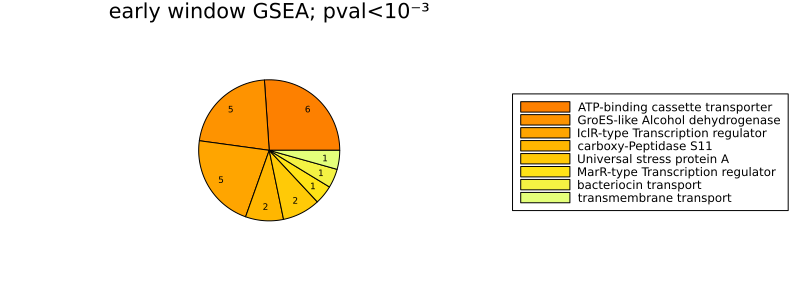

In [130]:
pie(ex, ey; title = "early window GSEA; pval<10⁻³", legend=:outerright, c=palette(:Wistia, 8; rev=true), size=(800, 300))
annotate!(.8*exanno, .8*eyanno, text.(string.(values(ew_paths)), 6))

In [131]:
savefig(joinpath(pdir, "earlywindow_piechart.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/GSEA_gnavus_uniformis/earlywindow_piechart.pdf"

### Middle window

In [64]:
mwdf_clustdf = CSV.read(joinpath(rdir, "middlewindow-cluster.tsv"), DataFrame; header=1, delim="\t", comment="#") |>
    df->filter(:Benjamini => x-> x.<1e-3, df);

In [126]:
mwdf_clustdf[mwdf_clustdf.Cluster .== 1, :]

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,GOTERM_BP_DIRECT,GO:0032196~transposition,24,24.0,2.52117e-23,"P76102, P0CF79, P19769, P0CE57, P0CF53, P0CE53, P76071",86,58,3407,16.3929,3.02541e-21,3.02541e-21,2.87414e-21
2,1,UP_KW_BIOLOGICAL_PROCESS,KW-0815~Transposition,24,24.0,1.94329e-22,"P76102, P0CF79, P19769, P0CE57, P0CF53, P0CE53, P76071",69,57,2344,14.3036,5.44122e-21,5.44122e-21,4.85823e-21
3,1,INTERPRO,IPR025948:HTH-like domain,12,12.0,9.37241e-18,"P0CF79, P19769, P0CF53",95,12,3935,41.4211,9.84103e-16,4.92051e-16,4.077e-16
4,1,INTERPRO,"IPR001584:Integrase, catalytic core",13,13.0,2.8227e-17,"P0CF79, P19769, P0CF53, P37007",95,16,3935,33.6546,2.96384e-15,9.87945e-16,8.18583e-16
5,1,UP_KW_BIOLOGICAL_PROCESS,KW-0233~DNA recombination,24,24.0,1.1153e-16,"P76102, P0CF79, P19769, P0CE57, P0CF53, P0CE53, P76071",69,95,2344,8.58215,3.10862e-15,1.56142e-15,1.39413e-15
6,1,UP_SEQ_FEATURE,DOMAIN:Integrase catalytic,13,13.0,1.15114e-16,"P0CF79, P19769, P0CF53, P37007",78,16,2826,29.4375,1.82077e-14,1.88787e-14,1.88787e-14
7,1,GOTERM_BP_DIRECT,GO:0006310~DNA recombination,24,24.0,3.13676e-16,"P76102, P0CF79, P19769, P0CE57, P0CF53, P0CE53, P76071",86,110,3407,8.64355,3.9968e-14,1.88205e-14,1.78795e-14
8,1,INTERPRO,"IPR008490:Transposase InsH, N-terminal",11,11.0,2.35649e-15,"P0CE57, P0CE53, P76071",95,12,3935,37.9693,2.44804e-13,3.09289e-14,2.56268e-14
9,1,COG_ONTOLOGY,"DNA replication, recombination, and repair",17,17.0,1.08024e-14,"P76102, P0CF79, P0CE57, P0CE53, P37007, P76071",29,37,630,9.98136,4.30767e-14,3.24071e-14,3.24071e-14


In [67]:
mwdf_clustdf[mwdf_clustdf.Cluster .!= 1, :]

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,2,INTERPRO,IPR015590:Aldehyde dehydrogenase domain,12,12.0,2.72392e-16,"P77455, P17445, P77445, P37685, P76149, P77674, P0A9Q7, P25526, P25553, P76217, P23883, P80668",95,14,3935,35.5038,2.33147e-14,4.76686e-15,3.94969e-15
2,2,INTERPRO,"IPR016162:Aldehyde dehydrogenase, N-terminal",12,12.0,2.72392e-16,"P77455, P17445, P77445, P37685, P76149, P77674, P0A9Q7, P25526, P25553, P76217, P23883, P80668",95,14,3935,35.5038,2.33147e-14,4.76686e-15,3.94969e-15
3,2,INTERPRO,"IPR016163:Aldehyde dehydrogenase, C-terminal",12,12.0,2.72392e-16,"P77455, P17445, P77445, P37685, P76149, P77674, P0A9Q7, P25526, P25553, P76217, P23883, P80668",95,14,3935,35.5038,2.33147e-14,4.76686e-15,3.94969e-15
4,2,INTERPRO,IPR016161:Aldehyde/histidinol dehydrogenase,12,12.0,9.99848e-16,"P77455, P17445, P77445, P37685, P76149, P77674, P0A9Q7, P25526, P25553, P76217, P23883, P80668",95,15,3935,33.1368,1.04916e-13,1.49977e-14,1.24267e-14
5,2,GOTERM_MF_DIRECT,"GO:0016620~oxidoreductase activity, acting on the aldehyde or oxo group of donors, NAD or NADP as acceptor",12,12.0,1.21552e-12,"P77455, P17445, P77445, P37685, P76149, P77674, P0A9Q7, P25526, P25553, P76217, P23883, P80668",93,21,3299,20.2704,1.40995e-10,1.41e-10,1.28845e-10
6,2,INTERPRO,"IPR016160:Aldehyde dehydrogenase, conserved site",8,8.0,1.22904e-10,"P17445, P37685, P76149, P25526, P25553, P76217, P23883, P80668",95,9,3935,36.8187,1.29049e-8,1.17317e-9,9.72058e-10
7,2,GOTERM_MF_DIRECT,GO:0004029~aldehyde dehydrogenase (NAD) activity,6,6.0,8.88865e-8,"P17445, P77445, P37685, P77674, P76217, P23883",93,6,3299,35.4731,1.03108e-5,2.7725e-6,2.53349e-6
8,2,UP_KW_LIGAND,KW-0520~NAD,14,14.0,2.58702e-6,"P77445, P77399, P77674, P38489, P76217, P17445, P0AFD6, P0A9Q7, P76083, P21177, P0ACY1, P25553, P23883, P80668",33,143,1481,4.39373,4.13916e-5,4.13924e-5,4.13924e-5
9,2,KEGG_PATHWAY,eco01120:Microbial metabolism in diverse environments,16,16.0,4.6502e-6,"P77455, P77445, P76149, P77399, P77674, P52647, P38489, P17117, P0A6V5, P37685, P0A9Q7, P76083, P21177, P25526, P25553, P80668",30,268,1737,3.45672,0.000209237,0.000209259,0.000172057


In [63]:
countmap(mwdf_clustdf.Cluster) |> 
    x->sort(x, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Int64, Int64} with 8 entries:
  1 => 18
  2 => 9
  5 => 7
  6 => 3
  7 => 2
  3 => 2
  4 => 1
  8 => 1

In [108]:
mw_paths = Dict(
    "DNA recombination & transposition" => 18,
    "aldehyde dehydrogenase (NAD) activity" => 10,
    "transmembrane transporter activity" => 7,
    "Rhodanese" => 3,
    "Nitroreductase (NADP dependent)" => 2,
    "Sugar phosphate transporter" => 2,
    "Butanoate metabolism" => 1,
) |> x->sort(x; byvalue=true, rev=true)
mx = string.(keys(mw_paths))
my = values(mw_paths) ./ sum(values(mw_paths));

In [110]:
myanno = sin.((cumsum(my).-(my/2)) .* 2π)
mxanno = cos.((cumsum(my).-(my/2)) .* 2π);

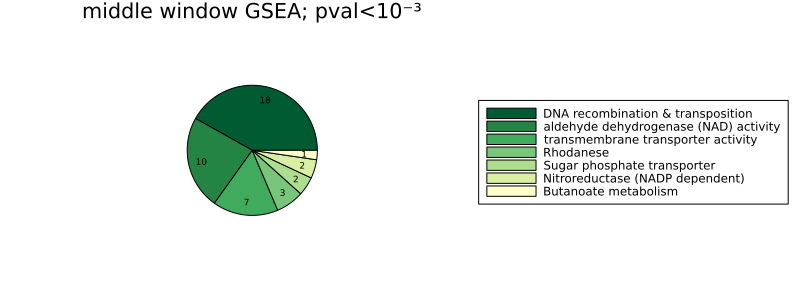

In [128]:
pie(mx, my; title = "middle window GSEA; pval<10⁻³", legend=:outerright, c=palette(:YlGn_7, 7, rev=true), size=(800,300))
annotate!(.8*mxanno, .8*myanno, text.(string.(values(mw_paths)), 6))

In [129]:
savefig(joinpath(pdir, "middlewindow_piechart.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/GSEA_gnavus_uniformis/middlewindow_piechart.pdf"

### Late window

In [85]:
lwdf_clustdf = CSV.read(joinpath(rdir, "latewindow-cluster.tsv"), DataFrame; header=1, delim="\t", comment="#")|>
    df->filter(:Benjamini => x-> x.<1e-3, df)

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,UP_SEQ_FEATURE,MOTIF:Nudix box,9,4.0,1.09259e-7,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",165,13,2826,11.8573,6.752e-5,6.75223e-5,6.71945e-5
2,1,INTERPRO,IPR000086:NUDIX hydrolase domain,9,4.0,1.63765e-7,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",217,14,3935,11.6573,6.02638e-5,1.50664e-5,1.37972e-5
3,1,UP_SEQ_FEATURE,DOMAIN:Nudix hydrolase,9,4.0,2.42415e-7,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",165,14,2826,11.0104,0.000149801,7.49062e-5,7.45426e-5
4,1,INTERPRO,IPR015797:NUDIX hydrolase domain-like,9,4.0,3.34443e-7,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",217,15,3935,10.8802,0.000123068,2.4615e-5,2.25415e-5
5,1,INTERPRO,"IPR020084:NUDIX hydrolase, conserved site",7,3.11111,4.45803e-6,"P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799",217,10,3935,12.6935,0.00163921,0.000182284,0.000166928
6,2,GOTERM_MF_DIRECT,"GO:0016773~phosphotransferase activity, alcohol group as acceptor",16,7.11111,3.34464e-12,"P55138, P0A9J6, P0AEW6, P77432, P32143, P76419, P37647, P11553, P37677, P76658, P30235, P33020, P32171, P09099, P45543, P77493",213,26,3299,9.53124,1.05357e-9,1.05356e-9,1.01342e-9
7,2,INTERPRO,IPR011611:Carbohydrate kinase PfkB,10,4.44444,7.33341e-10,"P0A9J6, P33020, P0AEW6, P32143, P76419, P37647, P45543, P77493, P76658, P30235",217,12,3935,15.1114,2.6987e-7,8.99565e-8,8.23787e-8
8,2,INTERPRO,"IPR002173:Carbohydrate/puine kinase, PfkB, conserved site",10,4.44444,7.33341e-10,"P0A9J6, P33020, P0AEW6, P32143, P76419, P37647, P45543, P77493, P76658, P30235",217,12,3935,15.1114,2.6987e-7,8.99565e-8,8.23787e-8
9,3,INTERPRO,"IPR013342:Mandelate racemase/muconate lactonizing enzyme, C-terminal",6,2.66667,9.13873e-6,"P77215, P51981, Q46915, P0AES2, P38104, Q6BF17",217,7,3935,15.5431,0.00335742,0.000305732,0.000279978


In [87]:
countmap(lwdf_clustdf.Cluster) |> 
    x->sort(x, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Int64, Int64} with 7 entries:
  1  => 5
  7  => 4
  5  => 3
  2  => 3
  16 => 1
  10 => 1
  3  => 1

In [122]:
lw_paths = Dict(
    "hydrolase, NUDIX-like" => 5,
    "symporter, Sodium:galactoside" => 4,
    "kinase, keto-sugar Carbohydrate" => 3,
    "kinase, carbohydrate/puine PfkB-like" => 3,
    "reductase, FAD/NAD-linked" => 1,
    "oxidoreductase, Pyridine nucleotide-disulphide " => 1,
    "mandelate racemase, Cell envelope biogenesis" => 1,
) |> x->sort(x; byvalue=true, rev=true)
lx = string.(keys(lw_paths))
ly = values(lw_paths) ./ sum(values(lw_paths));

In [123]:
lyanno = sin.((cumsum(ly).-(ly/2)) .* 2π)
lxanno = cos.((cumsum(ly).-(ly/2)) .* 2π);

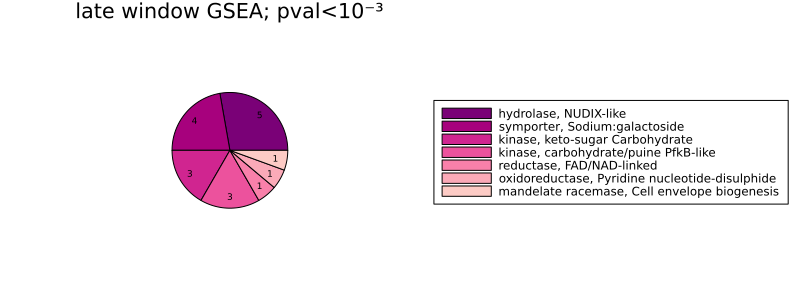

In [135]:
pie(lx, ly; title = "late window GSEA; pval<10⁻³", legend=:outerright, c=palette(:RdPu_7, 8, rev=true), size=(800, 300))
annotate!(.8*lxanno, .8*lyanno, text.(string.(values(lw_paths)), 6))

In [136]:
savefig(joinpath(pdir, "latewindow_piechart.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/GSEA_gnavus_uniformis/latewindow_piechart.pdf"

## GSEA pie chart (Full CSB)

In [137]:
rdir = projectdir("_research", "GSEA", "davidresults", "allCSB") |> mkpath;
pdir = plotsdir("GSEA_allCSB") |> mkpath;

### Early window

In [138]:
ewdf_clustdf = CSV.read(joinpath(rdir, "earlywindow-cluster.tsv"), DataFrame; header=1, delim="\t", comment="#") |>
    df->filter(:Benjamini => x-> x.<1e-3, df)

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,GOTERM_MF_DIRECT,GO:0016887~ATPase activity,15,21.1268,2.40041e-8,"P0A8J8, P0AAG3, P10346, P37774, P0AAI1, P45769, P0A9W3, P63389, P21507, P0AAF6, P0A9P6, P25888, P43672, P0A9S7, P21693",61,125,3299,6.48984,2.18437e-6,2.18437e-6,1.94433e-6
2,1,INTERPRO,IPR003439:ABC transporter-like,11,15.493,3.41845e-7,"P45769, P0A9U3, P0A9W3, P63389, P0AAF6, P43672, P0A9S7, P10346, P0AAG3, P37774, P0AAI1",66,77,3935,8.51732,3.58931e-5,1.79469e-5,1.5554e-5
3,1,INTERPRO,"IPR017871:ABC transporter, conserved site",10,14.0845,2.19224e-6,"P45769, P0A9W3, P63389, P0AAF6, P43672, P0A9S7, P10346, P0AAG3, P37774, P0AAI1",66,73,3935,8.16729,0.000230159,7.1201e-5,6.17076e-5
4,1,INTERPRO,IPR027417:P-loop containing nucleoside triphosphate hydrolase,16,22.5352,2.71242e-6,"P0A8J8, P0AAG3, P10346, P37774, P0AAI1, P0A9U3, P45769, P0A9W3, P63389, P21507, P0AAF6, P0A9P6, P25888, P43672, P0A9S7, P21693",66,228,3935,4.18394,0.000284764,7.1201e-5,6.17076e-5
5,1,GOTERM_MF_DIRECT,GO:0015424~amino acid-transporting ATPase activity,5,7.04225,3.3251e-6,"P45769, P0AAF6, P10346, P0AAG3, P37774",61,7,3299,38.63,0.000302539,0.000151292,0.000134667
6,1,INTERPRO,IPR003593:AAA+ ATPase domain,11,15.493,1.78588e-5,"P45769, P0A9U3, P0A9W3, P63389, P0AAF6, P43672, P0A9S7, P10346, P0AAG3, P37774, P0AAI1",66,118,3935,5.55791,0.00187343,0.000312528,0.000270858
7,1,KEGG_PATHWAY,eco02010:ABC transporters,10,14.0845,3.99605e-5,"P45769, P75851, P0AAF6, Q47539, P0A9S7, P10346, P0AAG3, P75853, P37774, P0AAI1",20,179,1737,4.85196,0.000439478,0.000439566,0.000439566
8,3,INTERPRO,IPR006685:Mechanosensitive ion channel MscS,4,5.6338,8.3075e-5,"P0AEB5, P0AAT4, P75783, P0C0S1",66,6,3935,39.7475,0.0086853,0.000969208,0.000839981
9,3,INTERPRO,"IPR011066:Mechanosensitive ion channel MscS, C-terminal",4,5.6338,8.3075e-5,"P0AEB5, P0AAT4, P75783, P0C0S1",66,6,3935,39.7475,0.0086853,0.000969208,0.000839981


In [139]:
countmap(ewdf_clustdf.Cluster) |> 
    x->sort(x, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Int64, Int64} with 5 entries:
  1 => 7
  5 => 6
  3 => 2
  4 => 1
  8 => 1

In [140]:
ew_paths = Dict(
    "ATP binding & transport" => 7,
    "RNA helicase, DEAD-box" => 6,
    "Mechanosensitive ion channel, MscS" => 2,
    "peptidyl-prolyl cis-trans isomerase activity" => 1,
    "Transmembrane transport" => 1,
) |> x->sort(x; byvalue=true, rev=true)
ex = string.(keys(ew_paths))
ey = values(ew_paths) ./ sum(values(ew_paths));

In [141]:
eyanno = sin.((cumsum(ey).-(ey/2)) .* 2π)
exanno = cos.((cumsum(ey).-(ey/2)) .* 2π);

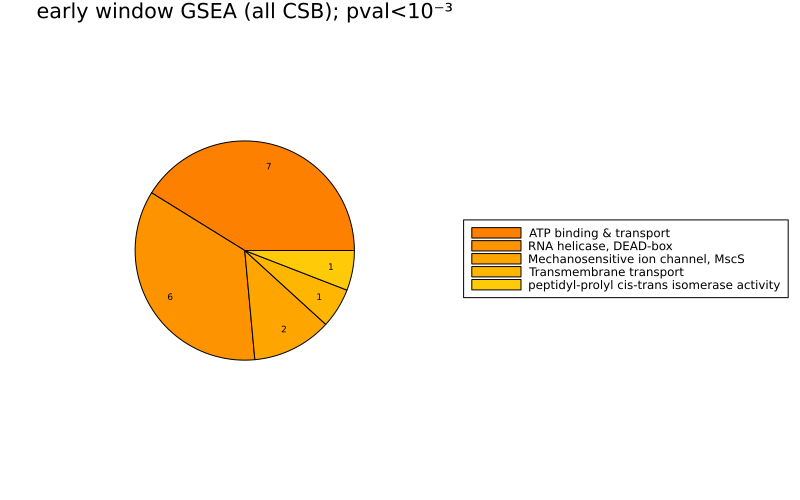

In [172]:
pie(ex, ey; title = "early window GSEA (all CSB); pval<10⁻³", legend=:outerright, c=palette(:Wistia, 8; rev=true), size=(800, 500))
annotate!(.8*exanno, .8*eyanno, text.(string.(values(ew_paths)), 6))

In [173]:
savefig(joinpath(pdir, "earlywindow_allCSB_piechart.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/GSEA_allCSB/earlywindow_allCSB_piechart.pdf"

### Middle window

In [144]:
mwdf_clustdf = CSV.read(joinpath(rdir, "middlewindow-cluster.tsv"), DataFrame; header=1, delim="\t", comment="#") |>
    df->filter(:Benjamini => x-> x.<1e-3, df);

In [147]:
mwdf_clustdf[mwdf_clustdf.Cluster .== 3, :]

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,3,INTERPRO,IPR006656:Molybdopterin oxidoreductase,10,13.3333,2.92264e-13,"P46923, P77561, P77374, P77783, P24183, P33937, P32176, P20099, P18775, P33225",74,14,3935,37.9826,3.7403e-11,9.35245e-12,7.16047e-12
2,3,INTERPRO,IPR009010:Aspartate decarboxylase-like domain,10,13.3333,7.19833e-13,"P46923, P77561, P77374, P77783, P24183, P33937, P32176, P20099, P18775, P33225",74,15,3935,35.4505,9.21432e-11,1.84277e-11,1.41087e-11
3,3,GOTERM_MF_DIRECT,GO:0030151~molybdenum ion binding,10,13.3333,7.77896e-12,"P46923, P77561, P77374, P77783, P24183, P33937, P32176, P20099, P18775, P33225",74,16,3299,27.8632,7.46784e-10,3.7339e-10,3.22827e-10
4,3,INTERPRO,IPR006657:Molydopterin dinucleotide-binding domain,9,12.0,1.13478e-11,"P46923, P77374, P77783, P24183, P33937, P32176, P20099, P18775, P33225",74,13,3935,36.8139,1.45252e-9,2.42087e-10,1.85348e-10
5,3,UP_KW_LIGAND,KW-0500~Molybdenum,11,14.6667,1.35571e-11,"P46923, P77561, P77374, Q46814, P77783, P24183, P33937, P32176, P20099, P18775, P33225",38,22,1481,19.4868,2.44027e-10,2.44027e-10,2.44027e-10
6,3,INTERPRO,"IPR006655:Molybdopterin oxidoreductase, prokaryotic, conserved site",8,10.6667,1.75766e-10,"P46923, P77374, P77783, P24183, P32176, P20099, P18775, P33225",74,11,3935,38.6732,2.2498e-8,3.21401e-9,2.46072e-9
7,3,GOTERM_MF_DIRECT,GO:0043546~molybdopterin cofactor binding,9,12.0,1.42803e-9,"P46923, P77374, P77783, P24183, P33937, P32176, P20099, P18775, P33225",74,18,3299,22.2905,1.37091e-7,4.56969e-8,3.95088e-8
8,3,INTERPRO,"IPR006311:Twin-arginine translocation pathway, signal sequence",9,12.0,2.46727e-9,"P46923, P77374, P77165, P77783, P24183, P33937, P32176, P18775, P33225",74,22,3935,21.7537,3.1581e-7,3.94762e-8,3.0224e-8
9,3,UP_SEQ_FEATURE,SIGNAL:Tat-type signal,9,12.0,2.03666e-8,"P46923, P77374, P77165, P77783, P24183, P33937, P32176, P18775, P33225",56,27,2826,16.8214,2.58656e-6,5.17313e-7,4.96946e-7


In [148]:
mwdf_clustdf[mwdf_clustdf.Cluster .!= 3, :]

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,INTERPRO,"IPR008490:Transposase InsH, N-terminal",11,14.6667,1.63716e-16,"P0CE57, P0CE53, P76071",74,12,3935,48.7444,1.42109e-14,1.04779e-14,8.02211e-15
2,1,UP_SEQ_FEATURE,DOMAIN:DUF772,9,12.0,1.08087e-13,P0CE57,56,9,2826,50.4643,1.37332e-11,6.86353e-12,6.59331e-12
3,1,INTERPRO,"IPR002559:Transposase, IS4-like",11,14.6667,2.07355e-13,"P0CE57, P0CE53, P76071",74,19,3935,30.7859,2.65459e-11,8.84715e-12,6.7736e-12
4,1,UP_SEQ_FEATURE,DOMAIN:DDE_Tnp_1,9,12.0,5.32325e-13,P0CE57,56,10,2826,45.4179,6.76087e-11,2.25351e-11,2.16479e-11
5,1,GOTERM_MF_DIRECT,GO:0004803~transposase activity,11,14.6667,9.7247e-9,"P0CE57, P0CE53, P76071",74,41,3299,11.9608,9.33571e-7,2.33393e-7,2.01788e-7
6,1,COG_ONTOLOGY,"DNA replication, recombination, and repair",10,13.3333,1.19298e-8,"P0CE57, P0CE53, P76071",16,37,630,10.6419,7.15789e-8,5.96491e-8,5.96491e-8
7,1,GOTERM_BP_DIRECT,"GO:0006313~transposition, DNA-mediated",11,14.6667,2.93914e-8,"P0CE57, P0CE53, P76071",68,51,3407,10.8065,3.20366e-6,3.20366e-6,2.88035e-6
8,1,UP_KW_BIOLOGICAL_PROCESS,KW-0815~Transposition,11,14.6667,4.21356e-8,"P0CE57, P0CE53, P76071",45,57,2344,10.0522,1.09552e-6,1.09552e-6,1.01125e-6
9,1,GOTERM_BP_DIRECT,GO:0032196~transposition,11,14.6667,1.07711e-7,"P0CE57, P0CE53, P76071",68,58,3407,9.50228,1.17404e-5,5.87026e-6,5.27784e-6


In [146]:
countmap(mwdf_clustdf.Cluster) |> 
    x->sort(x, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Int64, Int64} with 5 entries:
  3 => 17
  1 => 11
  2 => 5
  8 => 3
  5 => 2

In [169]:
mw_paths = Dict(
    "anarobic respiration, \nelectron transport chain, \nmolybdopterin binding" => 17,
    "DNA replication, recombination, and repair" => 11,
    "cell-cell signaling (c-di-GMP)" => 5,
    "Signal transduction via phosphotransfer (Hpt)" => 3,
    "posttranscriptional modification via \nPseudouridine synthase" => 2,
) |> x->sort(x; byvalue=true, rev=true)
mx = string.(keys(mw_paths))
my = values(mw_paths) ./ sum(values(mw_paths));

In [170]:
myanno = sin.((cumsum(my).-(my/2)) .* 2π)
mxanno = cos.((cumsum(my).-(my/2)) .* 2π);

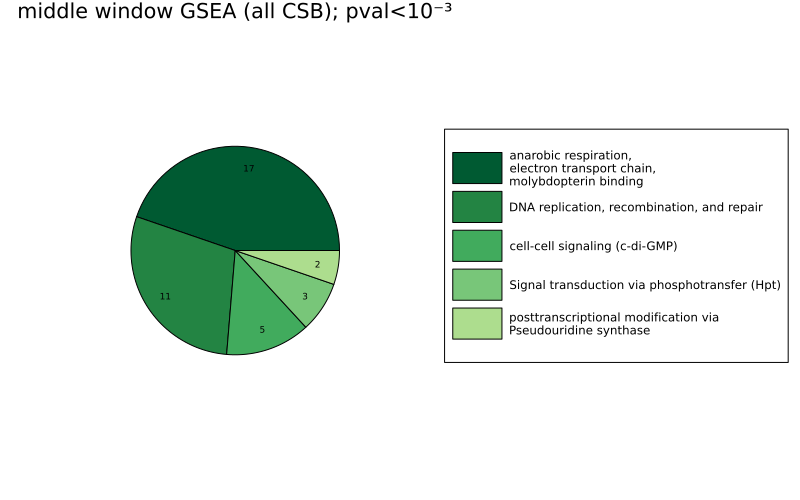

In [194]:
pie(mx, my; title = "middle window GSEA (all CSB); pval<10⁻³", legend=:outerright, c=palette(:YlGn_7, 7, rev=true), size=(800,500))
annotate!(.8*mxanno, .8*myanno, text.(string.(values(mw_paths)), 6))

In [195]:
savefig(joinpath(pdir, "middlewindow_allCSB_piechart.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/GSEA_allCSB/middlewindow_allCSB_piechart.pdf"

### Late window

In [177]:
lwdf_clustdf = CSV.read(joinpath(rdir, "latewindow-cluster.tsv"), DataFrame; header=1, delim="\t", comment="#")|>
    df->filter(:Benjamini => x-> x.<1e-3, df)

Row,Cluster,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
,Int64,String31,String,Int64,Float64,Float64,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,UP_SEQ_FEATURE,MOTIF:Nudix box,9,3.2967,3.77597e-7,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",193,13,2826,10.1371,0.000200862,0.000200882,0.000200127
2,1,INTERPRO,IPR000086:NUDIX hydrolase domain,9,3.2967,7.14029e-7,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",262,14,3935,9.65513,0.000317693,0.000105914,9.7822e-5
3,1,UP_SEQ_FEATURE,DOMAIN:Nudix hydrolase,9,3.2967,8.30045e-7,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",193,14,2826,9.41303,0.000441486,0.000220792,0.000219962
4,1,INTERPRO,IPR015797:NUDIX hydrolase domain-like,9,3.2967,1.44273e-6,"P43337, P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799, P37128",262,15,3935,9.01145,0.00064181,0.000160504,0.000148241
5,1,INTERPRO,"IPR020084:NUDIX hydrolase, conserved site",7,2.5641,1.34784e-5,"P0A776, P77788, P0AFC0, Q93K97, P08337, P52006, P45799",262,10,3935,10.5134,0.00597997,0.000749735,0.000692452
6,2,INTERPRO,"IPR006439:HAD-superfamily hydrolase, subfamily IA, variant 1",9,3.2967,1.354e-8,"P77247, P0ADP0, P77475, P0A8Y3, P77366, P0A8Y1, P77625, P31467, P64636",262,10,3935,13.5172,6.02528e-6,3.01265e-6,2.78247e-6
7,2,INTERPRO,"IPR023198:Phosphoglycolate phosphatase, domain 2",7,2.5641,2.01448e-6,"P77247, P77475, P0A8Y3, P77366, P0A8Y1, P77625, P31467",262,8,3935,13.1417,0.000896041,0.000179288,0.00016559
8,4,INTERPRO,IPR001303:Class II aldolase/adducin N-terminal,6,2.1978,7.02683e-6,"Q46890, P0AB87, P37680, P32169, P39306, P08203",262,6,3935,15.0191,0.00312206,0.000446705,0.000412575
9,4,SMART,SM01007:SM01007,6,2.1978,1.6831e-5,"Q46890, P0AB87, P37680, P32169, P39306, P08203",65,6,791,12.1692,0.000622558,0.000622747,0.000589085


In [178]:
countmap(lwdf_clustdf.Cluster) |> 
    x->sort(x, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Int64, Int64} with 6 entries:
  1  => 5
  4  => 2
  2  => 2
  6  => 1
  12 => 1
  8  => 1

In [190]:
lw_paths = Dict(
    "hydrolase, NUDIX-like" => 5,
    "class II aldolase/adducin" => 2,
    "HAD-superfamily hydrolase" => 2,
    "pyridine nucleotide-disulphide oxidoreductase" => 1,
    "electron transfer flavoprotein" => 1,
) |> x->sort(x; byvalue=true, rev=true)
lx = string.(keys(lw_paths))
ly = values(lw_paths) ./ sum(values(lw_paths));

In [191]:
lyanno = sin.((cumsum(ly).-(ly/2)) .* 2π)
lxanno = cos.((cumsum(ly).-(ly/2)) .* 2π);

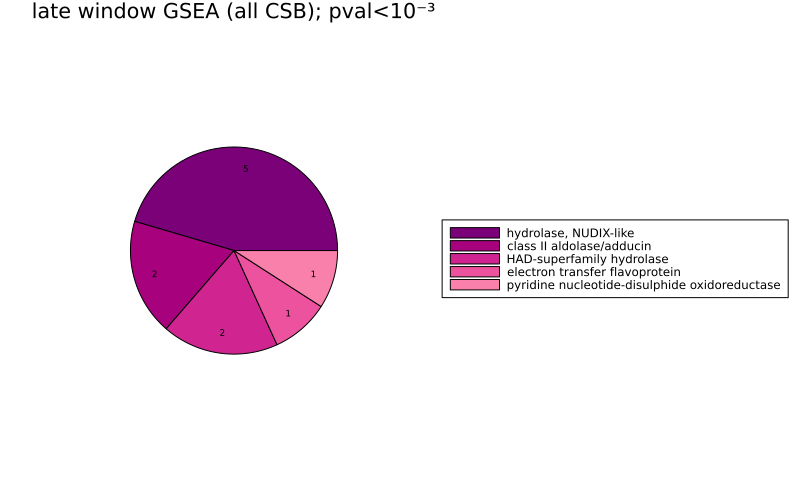

In [196]:
pie(lx, ly; title = "late window GSEA (all CSB); pval<10⁻³", legend=:outerright, c=palette(:RdPu_7, 8, rev=true), size=(800, 500))
annotate!(.8*lxanno, .8*lyanno, text.(string.(values(lw_paths)), 6))

In [197]:
savefig(joinpath(pdir, "latewindow_allCSB_piechart.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/GSEA_allCSB/latewindow_allCSB_piechart.pdf"